### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2 --max_classes_per_drift 0

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Functions

In [3]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [4]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [20]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [21]:
def plot_cumulative_subplots(title, accuracy_arrays, subtitles):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Re-learning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 10}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [22]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

CIFAR100 10 Tasks, 10 Classes Per Task

# ER

## Buffer 500

## Buffer 5000

### Without Drift

In [23]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-13-25-15-13-00-seq-cifar100-er-buf-5000-drift-6-n-2-severity-5-adaptation-0-cpd-0.json"
)
# 22.63, 22.76, 22.9, 22.97, 23.21
# 22.894 ± 0.1966316352980875
# plot_results(
#     er_5000_accuracy_array_without_drift, title="Baseline Accuracy of CIFAR-100 over Tasks"
# )

### With Permutation Drift in Tasks 3, 6

In [24]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-13-25-17-12-45-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-0-cpd-0.json"
)
# 15.35, 15.47, 15.56, 15.94, 16.54
# 15.772 ± 0.43180551177584525
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 3, 6",
# )

### With Permutation Drift in Tasks 3, 6 and Adaptive Relearning

In [25]:
er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./logs/01-14-25-00-28-42-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-1-cpd-0.json"
)
# 25.99, 26.03, 26.09, 26.13, 26.51
# 26.15 ± 0.18633303518163463
# plot_results(
#     er_5000_accuracy_array_with_drift_full_relearning,
#     title="Accuracy with Permutation Drift in Tasks 3, 6 and Adaptive Relearning",
# )

### With Permutation Drift in Tasks 3, 6 and Adaptive Buffer Resampling

In [26]:
er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./logs/01-14-25-01-32-25-seq-cifar100-er-buf-5000-drift-5-n-2-severity-5-adaptation-2-cpd-0.json"
)
# 25.62, 25.80, 26.05, 26.42, 26.45
# 26.068 ± 0.32944802321458827
# plot_results(
#     er_5000_accuracy_array_with_drift_buffer_resampling,
#     title="Accuracy with Permutation Drift in Tasks 3, 6 and Adaptive Buffer Resampling",
# )

### Cumulative Plots

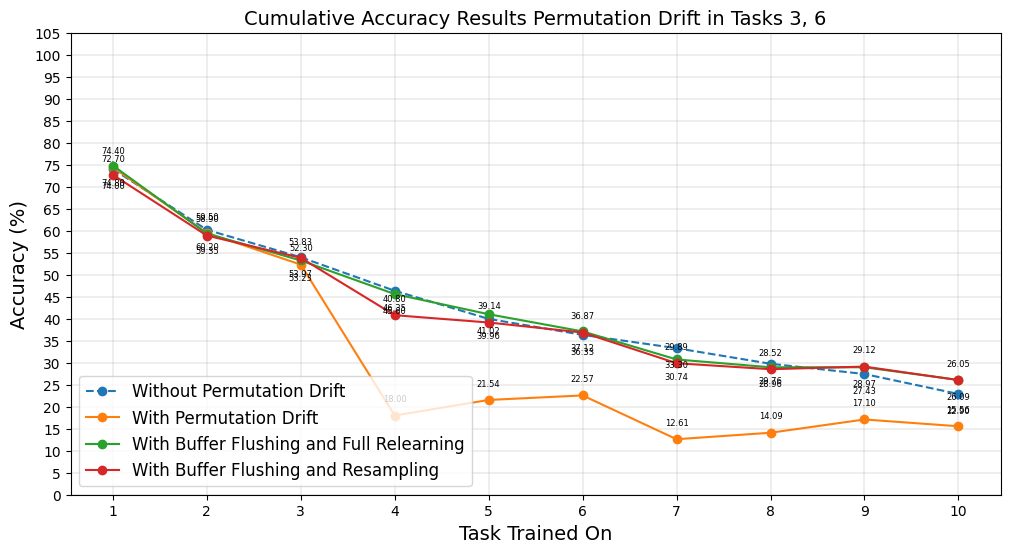

In [27]:
plot_cumulative_results(
    "Cumulative Accuracy Results Permutation Drift in Tasks 3, 6",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

In [ ]:
values = []
f"{np.mean(values)} ± {np.std(values)}"

## Buffer 500

In [ ]:
plot_cumulative_subplots(
    "CIL Accuracies with Drift in Tasks 3, 6 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        der_500_accuracy_array_without_drift,
        der_500_accuracy_array_with_drift,
        der_500_accuracy_array_with_drift_full_relearning,
        der_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER",
        "DER++",
    ],
)

## Buffer 5000

In [ ]:
plot_cumulative_subplots(
    "CIL Accuracies with Drift in Tasks 3, 6 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        der_5000_accuracy_array_without_drift,
        der_5000_accuracy_array_with_drift,
        der_5000_accuracy_array_with_drift_full_relearning,
        der_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER",
        "DER++",
    ],
)